# Load files from dropbox




In [1]:
!wget https://www.dropbox.com/scl/fi/phrnxa7d57ir05lmzw6o3/train.zip?rlkey=giuvx29xiwmq5y8av6oe6kwes&dl=0

!ls

--2024-02-29 12:53:46--  https://www.dropbox.com/scl/fi/phrnxa7d57ir05lmzw6o3/train.zip?rlkey=giuvx29xiwmq5y8av6oe6kwes
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0cc992db75b861e334a893eddc.dl.dropboxusercontent.com/cd/0/inline/COMTaKntAqKJexMaFvtztytoBaM83qVi8fkxn27WgZQDVSrhIhhTkNes3A1BNdwHSSc86JuLKKqmdcZyRzNGVY9F6dpT21wH8PrmW5XpcXbuzQA5f7yrVFrphteh0d9ONoGAPuj2SXICrysvC8vd5_jX/file# [following]
--2024-02-29 12:53:47--  https://uc0cc992db75b861e334a893eddc.dl.dropboxusercontent.com/cd/0/inline/COMTaKntAqKJexMaFvtztytoBaM83qVi8fkxn27WgZQDVSrhIhhTkNes3A1BNdwHSSc86JuLKKqmdcZyRzNGVY9F6dpT21wH8PrmW5XpcXbuzQA5f7yrVFrphteh0d9ONoGAPuj2SXICrysvC8vd5_jX/file
Resolving uc0cc992db75b861e334a893eddc.dl.dropboxusercontent.com (uc0cc992db75b861e334a893eddc.dl.dropboxusercontent.com)... 162.125.65.15, 2620:1

# unzip file and set seed


In [2]:
!unzip train.zip?rlkey=giuvx29xiwmq5y8av6oe6kwes

Archive:  train.zip?rlkey=giuvx29xiwmq5y8av6oe6kwes
replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N



# this block creates a csv file with file name as index 1 and label (0 as cat 1 as dog)for index 2

In [4]:
import os
import pandas as pd

folder_path = '/content/train'

data = []

file_list = os.listdir(folder_path)
file_list.sort()

# Iterate over sorted files in the folder
for file_name in file_list:
    if file_name.startswith('cat'):
        label = 0
    elif file_name.startswith('dog'):
        label = 1
    data.append([file_name, label])

df = pd.DataFrame(data, columns=['File Name', 'Label'])

csv_file = '/content/cat_dog_labels.csv'
df.to_csv(csv_file, index=False)

print(f"CSV file created: {csv_file}")
print(df)


CSV file created: /content/cat_dog_labels.csv
          File Name  Label
0         cat.0.jpg      0
1         cat.1.jpg      0
2        cat.10.jpg      0
3       cat.100.jpg      0
4      cat.1000.jpg      0
...             ...    ...
24994  dog.9995.jpg      1
24995  dog.9996.jpg      1
24996  dog.9997.jpg      1
24997  dog.9998.jpg      1
24998  dog.9999.jpg      1

[24999 rows x 2 columns]


In [5]:
from torch.utils.data import Dataset, DataLoader
import imageio as Image
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import os

# create class that extends dataset and returns images

In [6]:
class myDataset(Dataset):
  def __init__(self, path,csv_file,transform=None):
    self.df = pd.read_csv(csv_file)
    self.path = path
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    image_path = os.path.join(self.path, self.df.iloc[index, 0])
    image = Image.imread(image_path)
    label = self.df.iloc[index, 1]
    if self.transform:
        image = self.transform(image)
    return image, label


In [7]:
dataset = myDataset('/content/train','/content/cat_dog_labels.csv')

In [8]:
len(dataset)









24999

<ipython-input-6-7172c43dbcc6>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = Image.imread(image_path)


(-0.5, 499.5, 373.5, -0.5)

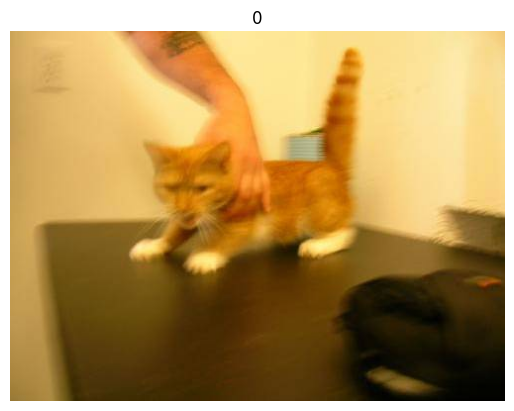

In [9]:
plt.imshow(dataset[0][0])
plt.title(dataset[0][1])
plt.axis('off')


# testing data augmentation

In [10]:
transformations = transforms.Compose([
        transforms.ToTensor(),

    transforms.RandomCrop(200),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomHorizontalFlip(),

])
transformed_dataset2 = myDataset('/content/train','/content/cat_dog_labels.csv',transform=transformations)


<ipython-input-6-7172c43dbcc6>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = Image.imread(image_path)


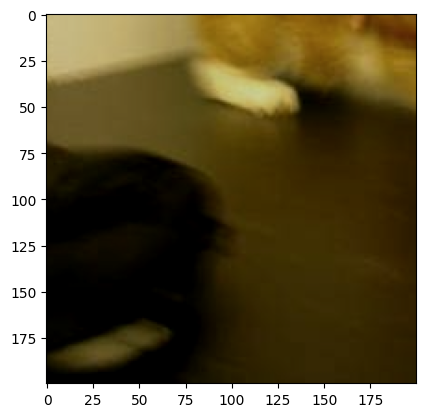

In [12]:

image, label = transformed_dataset2[0]

if torch.is_tensor(image):
    image = image.permute(1, 2, 0).numpy()

plt.imshow(image)
plt.show()


# transform images for compatibility and faster training


In [11]:
transformations = transforms.Compose([
        transforms.ToTensor(),
    transforms.Resize((28, 28)),

])
transformed_dataset = myDataset('/content/train','/content/cat_dog_labels.csv',transform=transformations)


# split data  

In [12]:
import torch
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(transformed_dataset))
test_size = len(transformed_dataset) - train_size
train_dataset, test_dataset = random_split(transformed_dataset, [train_size, test_size])


<ipython-input-5-7172c43dbcc6>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = Image.imread(image_path)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(

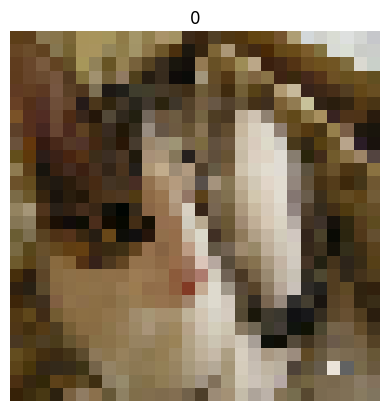

In [13]:

image, label = train_dataset[1000]

if torch.is_tensor(image):
    image = image.permute(1, 2, 0).numpy()

plt.imshow(image)
plt.title(label)
plt.axis('off')
plt.show()


# put training data into dataloader

In [14]:
train_loader = DataLoader(train_dataset,batch_size = 120)

batch = next(iter(train_loader))

<ipython-input-5-7172c43dbcc6>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = Image.imread(image_path)


# load pretrained model (resnet18) and change final layer

In [15]:
from torchvision.models import resnet18
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

net = resnet18(pretrained = True)

net.fc = nn.Linear(in_features = 512 , out_features = 2 , bias = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 156MB/s]


# freeze weights for all layers except final layer

In [16]:
# for param in net.parameters():
#     param.requires_grad = False
# net.fc.weight.requires_grad = True
# net.fc.bias.requires_grad = True

In [17]:
# print(net.fc.weight.requires_grad)  # Should be True
# print(net.fc.bias.requires_grad)    # Should be True


# training loop

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet Model
net = net.to(device)

# Freeze all layers except the final layer

mm = 0.5
# Optimizer and Learning Rate Scheduler
optimizer = optim.Adam(net.parameters(), lr=1e-4)

# Training Loop
num_epochs = 6
losses = []
for i in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        X, y = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        logits = net(X)
        loss = F.cross_entropy(logits, y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_loader)
    print(avg_loss)
    losses.append(avg_loss)


# Plotting
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.show()

<ipython-input-5-7172c43dbcc6>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = Image.imread(image_path)


KeyboardInterrupt: 

# create custom cnn with batch norm and drop out


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=16)  # Batch normalization for conv1
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=32)  # Batch normalization for conv2

        # Fully connected layers
        self.layer1 = nn.Linear(32*7*7, 256)
        self.dropout1 = nn.Dropout(0.5)  # Dropout for layer1
        self.layer2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)  # Dropout for layer2
        self.layer3 = nn.Linear(128, 2)

    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2))

        # Second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2))

        # Flatten and fully connected layers
        x = x.view(-1, 32*7*7)
        x = self.layer1(x)
        x = self.dropout1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = self.dropout2(x)
        x = F.relu(x)
        x = self.layer3(x)
        return x

cnnmodel = CNNModel().to(device)


# train

In [ ]:
cnnmodel = CNNModel().to(device)
# Loss
loss_fn = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(cnnmodel.parameters(), lr=1e-4)

epochs = 5
for epoch in range(epochs):
    total_loss = 0
    for features, labels in train_loader:
        optimizer.zero_grad()
        # Forward pass
        features = features.to(device)
        labels = labels.to(device)
        prediction = cnnmodel(features)  # Directly use the output
        loss = loss_fn(prediction, labels)
        total_loss += loss.item()
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1} and the loss {total_loss/len(train_loader)}')


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():
        for features, target_batch in test_loader:
            features = features.to(device)
            predictions = model(features)
            predicted_classes = torch.argmax(predictions, dim=1)
            preds.extend(predicted_classes.cpu().tolist())
            targets.extend(target_batch.cpu().tolist())

    return preds, targets


In [ ]:
# Evaluate ResNet model
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

resnet_preds, resnet_targets = evaluate_model(net, test_loader)

# Evaluate Custom CNN model
custom_cnn_preds, custom_cnn_targets = evaluate_model(cnnmodel, test_loader
                                                      )